In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

In [166]:
def E_dep_Gaussian(hw,hw0):
    #SEQUOIA energy resolution at Ei=190meV and 360 chopper frequency for high flux chopper
    #Model taken from SEQUOIA website (McVine calculator)
    
    sigma0 = (5.1630**2 + 1.5**2)**(1/2) #Includes an extra 1.5meV for lifetime        
    sigma1 = -0.029805 #Energy dependence of sigma (watch out for 3/2 exponent)    
    sigma2 = 4.6522e-5
    sigma3 = 5.4340e-8
    sigma = sigma0 + sigma1 * (hw0)  + sigma2 * (hw0)**2 + sigma3 * (hw0)**3 #Sigma is primarily function of final neutron energy
        
    y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp((-0.5 * (hw - (hw0))**2) / (sigma**2)) #Not automatically normalised
    
    #Ignores lifetime of neutron of ~1-1.5meV, otherwise use Pseudo-Voigt 2 function with fixed lifetime (Lorentzian width) instead of pure Gaussian
    return y.reshape(hw.shape)

def Conv_E_Gaussian(hw, S):

    idx = np.where(S > 0.001)
    
    if np.size(idx) == 0:
        hw0 = 0
    else:
        hw0 = hw[idx]
        
    Sconv = np.sum(S) * E_dep_Gaussian(hw, hw0) / np.sum(E_dep_Gaussian(hw, hw0))

    return Sconv

In [ ]:
from scipy import interpolate

x_indx, y_indx = np.meshgrid(np.arange(0, zs.shape[1]),
                             np.arange(0, zs.shape[0]))

# mask all invalid values
zs_masked = np.ma.masked_invalid(zs)

# retrieve the valid, non-Nan, defined values
valid_xs = x_indx[~zs_masked.mask]
valid_ys = y_indx[~zs_masked.mask]
valid_zs = zs_masked[~zs_masked.mask]

# generate interpolated array of z-values
zs_interp = interpolate.griddata((valid_xs, valid_ys), valid_zs.ravel(),
                                 (x_indx, y_indx), method='cubic')

# finally, plot the data 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X=xs, Y=ys, Z=zs_interp)

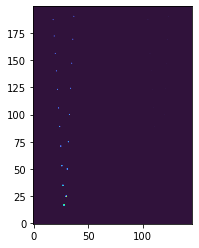

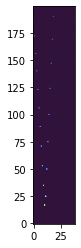

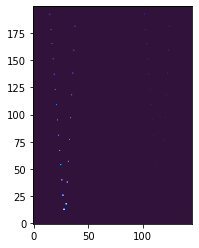

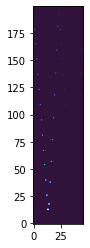

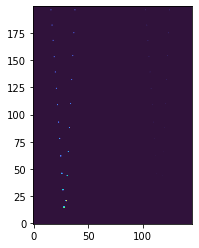

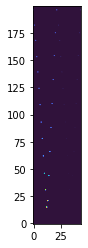

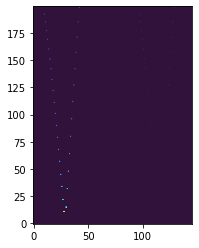

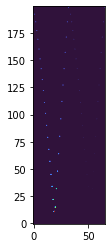

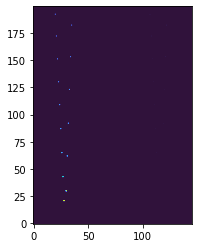

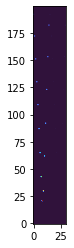

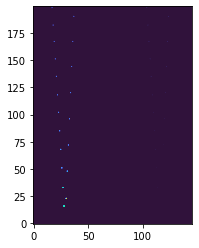

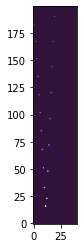

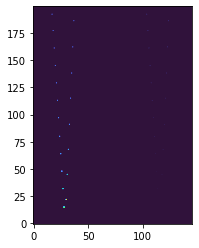

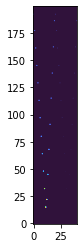

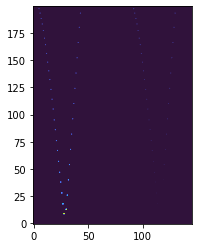

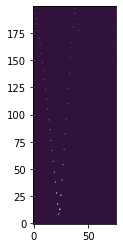

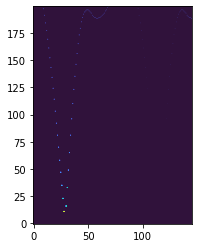

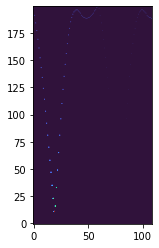

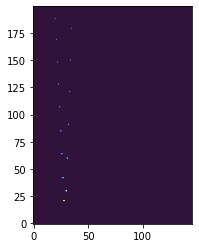

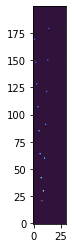

In [155]:
from scipy.interpolate import griddata
for num in [5, 10, 15, 20, 50, 90, 100, 120, 180, 400]:
    S = pd.read_csv('AFM_data1/Sqw_noBroadening_' + str(num) + '.csv', dtype=np.float64, header=None) #Kinda useless dispersion because most of it is out of range in energy
    S = np.array(S)

    plt.imshow(S, cmap='turbo',origin='lower')
    plt.show()

    A = [] 
    for i in range(S.shape[1]):
        if np.max(S[:,i]) > 0.000001:
            A.append(S[:,i])

    A = np.array(A).T
    plt.imshow(A, origin='lower',cmap='turbo')
    plt.show()
    #S[S == 0] = np.nan 
    #zs_masked = np.ma.masked_invalid(S)


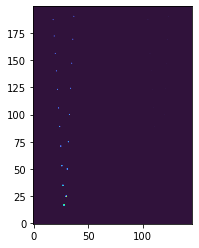

In [145]:
plt.imshow(S, cmap='turbo',origin='lower')

In [148]:
A.shape

(38, 200)

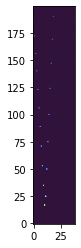

In [198]:
x_indx, y_indx = np.meshgrid(np.arange(0, S.shape[1]), np.arange(0, S.shape[0]))

grid_z0 = griddata(points, valid_zs, (x_indx, y_indx), method='nearest')

In [216]:
near_img = cv2.resize(S,None, fx = 1/5, fy = 1/5, interpolation = cv2.INTER_LINEAR)

In [213]:
x_broaden = 5
near_img = ndimage.gaussian_filter(near_img.T, x_broaden, 1).T

Sn = cv2.resize(near_img,None, fx = 1/5, fy = 1/5)


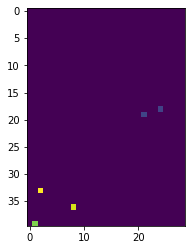

In [217]:
plt.imshow(near_img)

In [248]:
#Loading files
import cv2
from tqdm import tqdm

x_broaden = 6
from scipy import ndimage
from scipy.ndimage import median_filter

base_path = 'AFM_data3/'
for num in tqdm(np.arange(1,601)):
    hw = pd.read_csv(base_path + 'Elist_' + str(num) + '.csv', dtype=np.float64, header=None)
    hw = [int(x) for x in hw]
    hw = np.array(hw)
    S = pd.read_csv(base_path + 'Sqw_noBroadening_' + str(num) + '.csv', dtype=np.float64, header=None) #Kinda useless dispersion because most of it is out of range in energy

    S = np.array(S)
    Sconv = np.empty(S.shape)

    for i in range(S.shape[1]):

        Sconv[:,i] = Conv_E_Gaussian(hw[1:], S[:,i]) #Energy array 2 elements longer than S(Q,w). No idea why. Fix!
    
    Sconv = ndimage.gaussian_filter1d(Sconv.T, x_broaden, 1).T
    
    np.savetxt(base_path + 'Sqw_withCorrectBroadening_' + str(num) + '.csv', Sconv, delimiter=",")
    
    # plt.imshow(Sconv[0:120,:],origin= 'lower', cmap='turbo')#Seems to work. Check on better dispersion (below energy cutoff)
    # plt.colorbar()
    # plt.show()

    

100%|██████████| 600/600 [01:14<00:00,  8.07it/s]
